In [80]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
#import gt4py


In [81]:
# Initialize model parameters
M = 64 # args.M
N = 64 # args.N
M_LEN = M + 1
N_LEN = N + 1
L_OUT = True # args.L_OUT
VIS = True
VIS_DT=1
ITMAX = 100
dt = 90.
tdt = dt
dx = 100000.
dy = 100000.
fsdx = 4. / (dx)
fsdy = 4. / (dy)
a = 1000000.
alpha = 0.001
el = N * dx
pi = 4. * np.arctan(1.)
tpi = 2. * pi
di = tpi / M
dj = tpi / N
dtheta = tpi / M
pcf = (pi * pi * a * a) / (el * el)
SIZE = M_LEN * N_LEN

# Model Variables
u = np.zeros((M_LEN, N_LEN))
v = np.zeros((M_LEN, N_LEN))
p = np.zeros((M_LEN, N_LEN))
unew = np.zeros((M_LEN, N_LEN))
vnew = np.zeros((M_LEN, N_LEN))
pnew = np.zeros((M_LEN, N_LEN))
uold = np.zeros((M_LEN, N_LEN))
vold = np.zeros((M_LEN, N_LEN))
pold = np.zeros((M_LEN, N_LEN))
uvis = np.zeros((M_LEN, N_LEN))
vvis = np.zeros((M_LEN, N_LEN))
pvis = np.zeros((M_LEN, N_LEN))
cu = np.zeros((M_LEN, N_LEN))
cv = np.zeros((M_LEN, N_LEN))
z = np.zeros((M_LEN, N_LEN))
h = np.zeros((M_LEN, N_LEN))
psi = np.zeros((M_LEN, N_LEN))

    

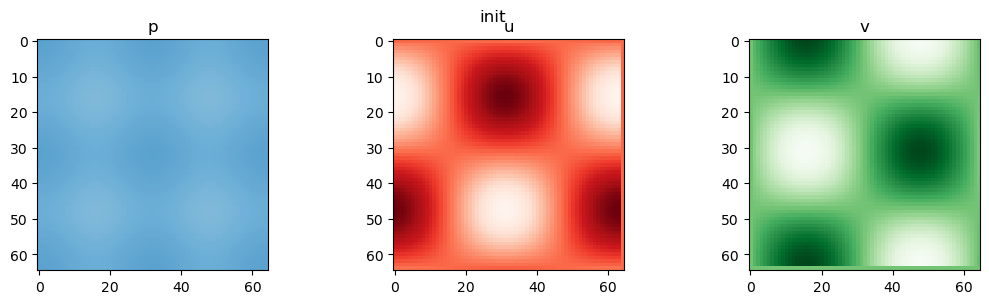

In [82]:
%matplotlib inline
# Initial values of the stream function and p
for i in range(M + 1):
    for j in range(N + 1):
        psi[i, j] = a * np.sin((i + .5) * di) * np.sin((j + .5) * dtheta)
        p[i, j] = pcf * (np.cos(2. * (i) * di) + np.cos(2. * (j) * dtheta)) + 50000.
            
# Calculate initial u and v
    for i in range(M):
        for j in range(N):
            u[i+1,j] = -(psi[i+1,j+1] - psi[i+1,j]) / dy
            v[i,j+1] = (psi[i+1,j+1] - psi[i,j+1]) / dx
            

if VIS==True:
    live_plot3(u,v,p, "init")
    #print(p.max())
    #print(p.min())
    #print(u.max())
    #print(u.min())
    #print(v.max())
    #print(v.min())




 

In [83]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
    

def live_plot3(fu, fv, fp, title=''):
    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

    pos1 = ax1.imshow(fp, cmap='Blues', vmin=49995, vmax=50005,interpolation='none')
    ax1.set_title('p')
    pos2 = ax2.imshow(fu, cmap='Reds', vmin=-1, vmax=1,interpolation='none')
    ax2.set_title('u')
    pos3 = ax3.imshow(fv, cmap='Greens',vmin=-1, vmax=1,interpolation='none')
    ax3.set_title('v')

    fig.suptitle(title)
    #plt.xlabel('x')
    #plt.ylabel('y')
    plt.show()



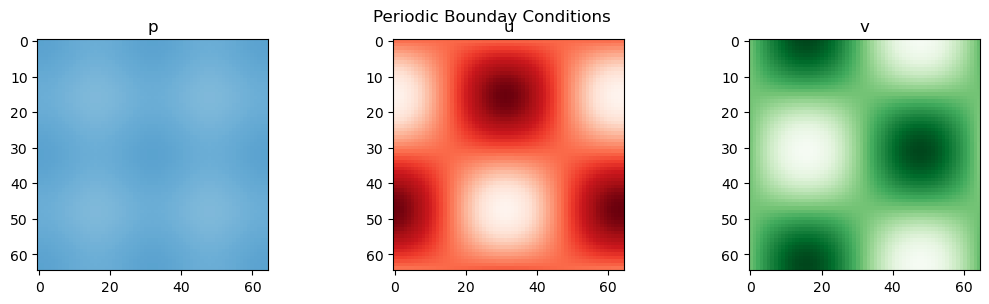

In [84]:
%matplotlib inline

# Periodic Boundary conditions

u[0, :] = u[M, :]
v[M, 1:] = v[0, 1:]
u[1:, N] = u[1:, 0]
v[:, 0] = v[:, N]

u[0, N] = u[M, 0]
v[M, 0] = v[0, N]




if VIS==True:
    live_plot3(u,v,p, "Periodic Bounday Conditions")
    
# Save initial conditions
uold = np.copy(u)
vold = np.copy(v)
pold = np.copy(p)


In [85]:
# Print initial conditions
if L_OUT:
    print(" Number of points in the x direction: ", M)
    print(" Number of points in the y direction: ", N)
    print(" grid spacing in the x direction: ", dx)
    print(" grid spacing in the y direction: ", dy)
    print(" time step: ", dt)
    print(" time filter coefficient: ", alpha)
    print(" Initial p:\n", p.diagonal()[:-1])
    print(" Initial u:\n", u.diagonal()[:-1])
    print(" Initial v:\n", v.diagonal()[:-1])
        


 Number of points in the x direction:  64
 Number of points in the y direction:  64
 grid spacing in the x direction:  100000.0
 grid spacing in the y direction:  100000.0
 time step:  90.0
 time filter coefficient:  0.001
 Initial p:
 [50000.48191428 50000.47265443 50000.44523074 50000.40069708
 50000.34076485 50000.26773723 50000.18442061 50000.09401681
 50000.         49999.90598319 49999.81557939 49999.73226277
 49999.65923515 49999.59930292 49999.55476926 49999.52734557
 49999.51808572 49999.52734557 49999.55476926 49999.59930292
 49999.65923515 49999.73226277 49999.81557939 49999.90598319
 50000.         50000.09401681 50000.18442061 50000.26773723
 50000.34076485 50000.40069708 50000.44523074 50000.47265443
 50000.48191428 50000.47265443 50000.44523074 50000.40069708
 50000.34076485 50000.26773723 50000.18442061 50000.09401681
 50000.         49999.90598319 49999.81557939 49999.73226277
 49999.65923515 49999.59930292 49999.55476926 49999.52734557
 49999.51808572 49999.52734557 4

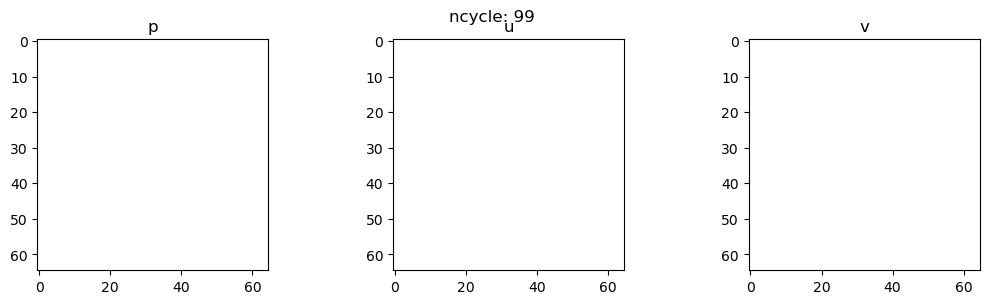

In [86]:
%matplotlib inline

time = 0.0 
# Main time loop
for ncycle in range(ITMAX):
    if((ncycle%100==0) & VIS==False):
        print("cycle number ", ncycle)
    # Calculate cu, cv, z, and h
    for i in range(M):
        for j in range(N):
            cu[i + 1, j] = .5 * (p[i + 1, j] + p[i, j]) * u[i + 1, j]
            cv[i, j + 1] = .5 * (p[i, j + 1] + p[i, j]) * v[i, j + 1]
            z[i + 1, j + 1] = (fsdx * (v[i + 1, j + 1] - v[i, j + 1]) -
                            fsdy * (u[i + 1, j + 1] - u[i, j + 1] )
                            ) / (p[i, j] + p[i + 1, j] + p[i + 1, j + 1] + p[i, j + 1])
            h[i, j] = p[i, j] + 0.25 * (u[i + 1, j] * u[i + 1, j] + u[i, j] * u[i, j] +
                                    v[i, j + 1] * v[i, j + 1] + v[i, j] * v[i, j])
   
    # # Periodic Boundary conditions
    cu[0, :] = cu[M, :]
    h[M, :] = h[0, :]
    cv[M, 1:] = cv[0, 1:]
    z[0, 1:] = z[M, 1:]
    
    cv[:, 0] = cv[:, N]
    h[:, N] = h[:, 0]
    cu[1:, N] = cu[1:, 0]
    z[1:, N] = z[1:, 0]
        
    cu[0, N] = cu[M, 0]
    cv[M, 0] = cv[0, N]
    z[0, 0] = z[M, N]
    h[M, N] = h[0, 0]
        
    # Calclulate new values of u,v, and p
    tdts8 = tdt / 8.
    tdtsdx = tdt / dx
    tdtsdy = tdt / dy
        
    for i in range(M):
        for j in range(N):
            unew[i+1,j] = uold[i+1,j] + tdts8 * (z[i+1,j+1] + z[i+1,j]) * (cv[i+1,j+1] + cv[i+1,j] + cv[i,j+1] + cv[i,j]) - tdtsdx * (h[i+1,j] - h[i,j])
            vnew[i,j+1] = vold[i,j+1] - tdts8 * (z[i+1,j+1] + z[i,j+1]) * (cu[i+1,j+1] + cu[i+1,j] + cu[i,j+1] + cu[i,j]) - tdtsdy * (h[i,j+1] - h[i,j])
            pnew[i,j] = pold[i,j] - tdtsdx * (cu[i+1,j] - cu[i,j]) - tdtsdy * (cv[i,j+1] - cv[i,j])
                
    
    # Periodic Boundary conditions
    unew[0, :] = unew[M, :]
    pnew[M, :] = pnew[0, :]
    vnew[M, 1:] = vnew[0, 1:]
    unew[1:, N] = unew[1:, 0]
    vnew[:, 0] = vnew[:, N]
    pnew[:, N] = pnew[:, 0]
    
    unew[0, N] = unew[M, 0]
    vnew[M, 0] = vnew[0, N]
    pnew[M, N] = pnew[0, 0]
    
    time = time + dt

    if(ncycle > 1):
        for i in range(M_LEN):
            for j in range(N_LEN):
                uold[i,j] = u[i,j] + alpha * (unew[i,j] - 2. * u[i,j] + uold[i,j])
                vold[i,j] = v[i,j] + alpha * (vnew[i,j] - 2. * v[i,j] + vold[i,j])
                pold[i,j] = p[i,j] + alpha * (pnew[i,j] - 2. * p[i,j] + pold[i,j])

        for i in range(M_LEN):
                for j in range(N_LEN):
                    u[i,j] = unew[i,j]
                    v[i,j] = vnew[i,j]
                    p[i,j] = pnew[i,j]

    else:
        tdt = tdt+tdt

        uold = np.copy(u)
        vold = np.copy(v)
        pold = np.copy(p)
        u = np.copy(unew)
        v = np.copy(vnew)
        p = np.copy(pnew)

    if((VIS == True) & (ncycle%VIS_DT==0)):
        live_plot3(u, v, p, "ncycle: " + str(ncycle))
        



In [87]:
 # Print initial conditions
if L_OUT:
        print("cycle number ", ITMAX)
        print(" diagonal elements of p:\n", pnew.diagonal()[:-1])
        print(" diagonal elements of u:\n", unew.diagonal()[:-1])
        print(" diagonal elements of v:\n", vnew.diagonal()[:-1])

cycle number  100
 diagonal elements of p:
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
 diagonal elements of u:
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
 diagonal elements of v:
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
